In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from numpy.random import uniform, dirichlet

from plot_dirichlet import Dirichlet, PlotDirichlet

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
plot_dirichlet = PlotDirichlet(corners)

np.random.seed(seed=0)

# Environmental parameter discretization
N = 200
x = np.linspace(0,1,200)

# Probabilistic multivariate fusion considering uncertainty and ignorance

## Defining prior confidence values

Prior confidence is a learned deterministic function which characterizes a model given the environmental context. Examples of quantifiable parameters which affect performance are
- Luminosity (bright or dark condition)
- Air moisture (rain and fog)
- Approximate distance to measurement (capturing the difference between 5 and 50 m)

In this example, we only characterize models by approximate distance, and assume no detrimental weather effects.

Application example: Object classification by fusing a camera and LiDAR model in varying environmental luminance level (bright daylight to night time), keeping all other conditions constant. In this example, the camera model performs well in good and bright conditions, while the LiDAR model is invariant to external luminance.

### LiDAR model prior

Prior confidence in LiDAR model @ light : 0.600
                                @ dusk  : 0.600
                                @ dark  : 0.600



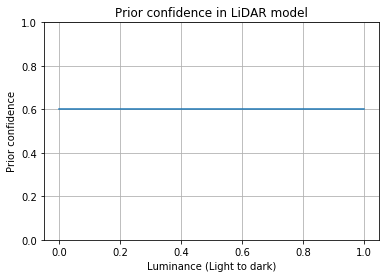

In [2]:
##################
#  LiDAR model
##################
lidar_conf_val = 0.6

def conf_lidar_func(val):
    return val

conf_lidar = np.zeros(N)
for i in range(N):
    conf_lidar[i] = conf_lidar_func(lidar_conf_val)

print(f"Prior confidence in LiDAR model @ light : {conf_lidar[0]:.3f}")
print(f"                                @ dusk  : {conf_lidar[int(N/2)]:.3f}")
print(f"                                @ dark  : {conf_lidar[-1]:.3f}\n")

plt.plot(x, conf_lidar)
plt.title("Prior confidence in LiDAR model")
plt.xlabel("Luminance (Light to dark)")
plt.ylabel("Prior confidence")
plt.grid()
plt.ylim(0,1)
plt.show()

### Camera model prior

Prior confidence in camera model @ light : 0.950
                                 @ dusk  : 0.629
                                 @ dark  : 0.100



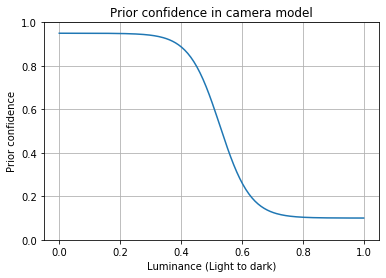

In [3]:
##################
#  Camera model
##################
def conf_camera_func(x, mid, max_val, min_val):
    val = 1 / (1 + np.exp(-0.1*(x - mid)))
    val = 1 - val 
    val = max_val * val
    val += min_val
    return val

conf_camera = np.zeros(N)
for i in range(N):
    conf_camera[i] = conf_camera_func(i, 105, 0.85, 0.1)

print(f"Prior confidence in camera model @ light : {conf_camera[0]:.3f}")
print(f"                                 @ dusk  : {conf_camera[int(N/2)]:.3f}")
print(f"                                 @ dark  : {conf_camera[-1]:.3f}\n")

plt.plot(x, conf_camera)
plt.title("Prior confidence in camera model")
plt.xlabel("Luminance (Light to dark)")
plt.ylabel("Prior confidence")
plt.grid()
plt.ylim(0,1)
plt.show()

## Case 1: Ideal camera model - output correctly reflect uncertainity

As the environment becomes darker, correctly categorizing objects with a camera becomes more difficult. This behavior is ideally represented by an output which goes towards uniform distribution, that is 'unknown', as luminance goes towards zero.

The LiDAR on the other hand, is invariant to outside brightness and outputs the same prediction for all luminance level.

### Model observations (evidence)

The observation function represents the classification probability vector as outputted by the corresponding classification model.

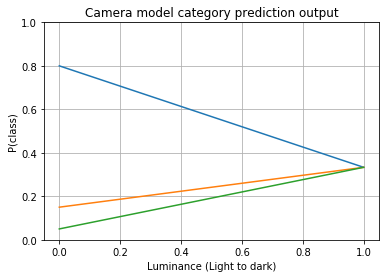

In [4]:
##################
#  Camera model
##################
def p_camera_class_func(x, a_0, b_0, c_0, a, b, c):
    C = np.zeros((3,N))
    
    for i, lum in enumerate(x):
        C[0,i] = a_0 + lum * a
        C[1,i] = b_0 + lum * b
        C[2,i] = c_0 + lum * c
        
    return C

a_0 = 0.8
b_0 = 0.15
c_0 = 0.05

a = -7.0/15.0
b = 11.0/60.0
c = 17.0/60.0

p_camera = p_camera_class_func(x, a_0, b_0, c_0, a, b, c)

plt.plot(x, p_camera[0])
plt.plot(x, p_camera[1])
plt.plot(x, p_camera[2])
plt.title("Camera model category prediction output")
plt.xlabel("Luminance (Light to dark)")
plt.ylabel("P(class)")
plt.grid()
plt.ylim(0,1)
plt.show()

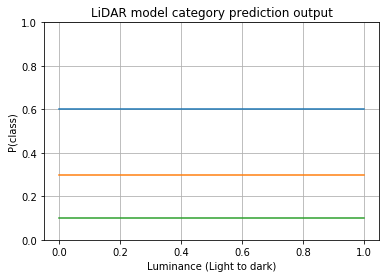

In [5]:
##################
#  LiDAR model
##################
def p_lidar_class_func(x, a, b, c):
    C = np.zeros((3,N))
    
    for i, lum in enumerate(x):
        C[0,i] = a
        C[1,i] = b
        C[2,i] = c
        
    return C

a = 0.6
b = 0.3
c = 0.1

p_lidar = p_lidar_class_func(x, a, b, c)

plt.plot(x, p_lidar[0])
plt.plot(x, p_lidar[1])
plt.plot(x, p_lidar[2])
plt.title("LiDAR model category prediction output")
plt.xlabel("Luminance (Light to dark)")
plt.ylabel("P(class)")
plt.grid()
plt.ylim(0,1)
plt.show()

### Integrate observations and priors

The integration is based on representing the observations and priors in terms of probabilistic distributions. In this problem the domain of the random variable $Y$ consists of $K=3$ states ($Y = 1$ : 'car', $Y = 2$ : 'truck', and $Y = 3$ : 'ambulance'). Each model outputs a classification vector $c = (c_1, \dots, c_k, \dots c_K)$ where each entry $c_k$ corresponds to class probability. 'Unknown' or 'no information' is adequately represented by the uniform categorical distribution $c_k = 1/K \; \forall \; k \in (1, \dots, K)$ which contains no information and therefore can be thought of as complete ignorance regarding the true state (because there must be a single true state!).

The following computations are performed separately for each luminansce value.

### Observations as Categorical (or Multinomial) distributions

Observations, or model output, are modeled as categorical distributions corresponding to the output class probability vector $c$.

$\mathbb{E}[Y=k] = c_k \: \forall \: k \in (1, \dots, K)$

$\sum^K_{k=1} c_k = 1$

In [6]:
K = 3

### Priors as Dirichlet distributions

The prior distribution is designed to "push" the posterior distribution towards $P(Y=1) = 1/K$ ('unknown') in proportion to the specified prior confidence value $C \in (0,1)$. Such a distribution is represented by a Dirichlet distribution centered at $\mu_k = 1/K \: \forall \: k \in (1, \dots, K)$ with variance parametrized by $C$.

$\sigma^2 = C \: \sigma^2_{max}(K)$

where

$\sigma^2_{max} = \frac{K -1}{K^3 + K^2}$

The parameters for the corresponding Dirichlet distribution are then computed as

$a_{prior} = \frac{1}{C \: \sigma^2_{max}(K)} \frac{K - 1}{K^3} - \frac{1}{K}$

This function for $a_{prior}$ has posesses the following necessary properties

$a_{prior} \rightarrow 1$ as $C \rightarrow 1$ (The prior becomes uniform as confidence in the observation increases)

$a_{prior} \rightarrow \infty$ as $C \rightarrow 0$ (The prior becomes stronger as confidence in the observation decreases)

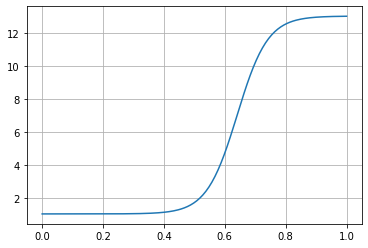

In [7]:
a_prior_camera = np.zeros(N)  # Assumes all classes have the same reliability!

sigma_max = (K - 1.0)/(K**3 + K**2)

for i,conf in enumerate(conf_camera):
    
    a_prior_camera[i] = (1.0 / (conf * sigma_max) ) * ((K - 1.0) / (K**3)) - 1.0 / K
    
plt.plot(x, a_prior_camera)
plt.grid()
plt.show()

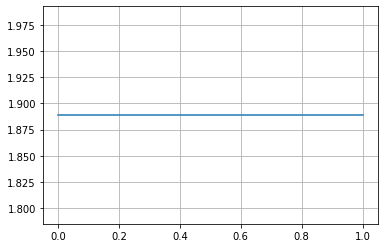

In [8]:
a_prior_lidar = np.zeros(N)  # Assumes all classes have the same reliability!

sigma_max = (K - 1.0)/(K**3 + K**2)

for i,conf in enumerate(conf_lidar):
    
    a_prior_lidar[i] = (1.0 / (conf * sigma_max) ) * ((K - 1.0) / (K**3)) - 1.0 / K

plt.plot(x, a_prior_lidar)
plt.grid()
plt.show()

#### Integration of observations and priors

The Dirichlet distribution is a conjugate prior to the Categorical (or Multinomial) distribution, meaning the posterior distribution becomes another Dirichlet distribution with parameters that can be quickly obtained as an analytical solution.

$a_{post,k} = c_k + a_{prior} - 1$

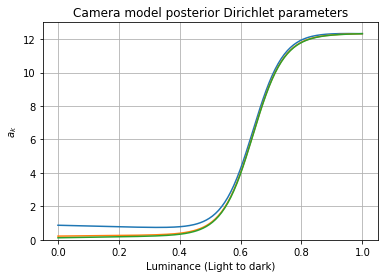

0.335
0.333
0.333
[12.315534185300104, 12.253473883792566, 12.243926145099099]


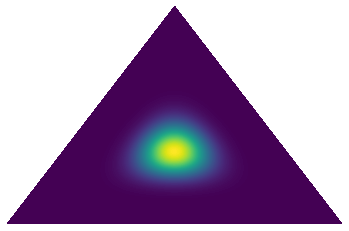

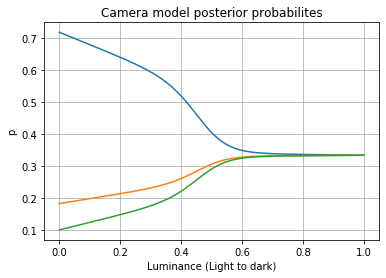

In [9]:
a_post_camera = np.zeros((3,N))  # Class-wise posterior probability distribution parameters

for i in range(N):
    for k in range(K):
        
        a_post_camera[k, i] = p_camera[k, i] + a_prior_camera[i] - 1.0

plt.plot(x, a_post_camera[0])
plt.plot(x, a_post_camera[1])
plt.plot(x, a_post_camera[2])
plt.title("Camera model posterior Dirichlet parameters")
plt.xlabel("Luminance (Light to dark)")
plt.ylabel("$a_k$")
plt.grid()
plt.ylim(0,13)
plt.show()


# Visualize distribution

n = 180
prior_alpha = [a_post_camera[0,n], a_post_camera[1,n], a_post_camera[2,n]]
prior_alpha_0 = sum(prior_alpha)

print(f"{prior_alpha[0]/prior_alpha_0:.3f}")
print(f"{prior_alpha[1]/prior_alpha_0:.3f}")
print(f"{prior_alpha[2]/prior_alpha_0:.3f}")

print(prior_alpha)

f, axes = plt.subplots(figsize=(6,4))
ax = axes#[0, 0]
dist = Dirichlet(prior_alpha)
ax = plot_dirichlet.draw_pdf_contours(ax, dist, prior_alpha)
plt.show()


# Visualize posterior probailities

p_post_camera = np.zeros((3,N))
for i in range(N):
    
    prior_alpha_0 = np.sum(a_post_camera[:,i])
    p_post_camera[0,i] = a_post_camera[0,i] / prior_alpha_0
    p_post_camera[1,i] = a_post_camera[1,i] / prior_alpha_0
    p_post_camera[2,i] = a_post_camera[2,i] / prior_alpha_0

plt.plot(x, p_post_camera[0])
plt.plot(x, p_post_camera[1])
plt.plot(x, p_post_camera[2])
plt.title("Camera model posterior probabilites")
plt.xlabel("Luminance (Light to dark)")
plt.ylabel("p")
plt.grid()
plt.show()

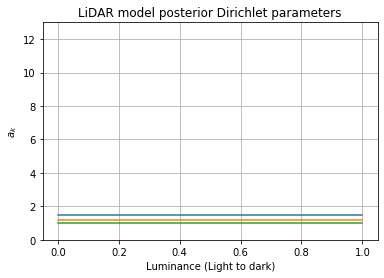

0.406
0.324
0.270
[1.488888888888889, 1.188888888888889, 0.9888888888888892]


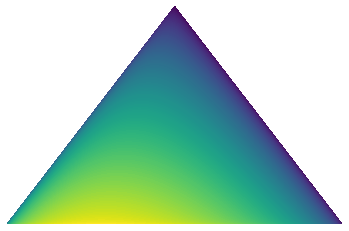

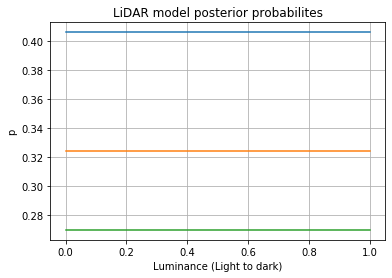

In [10]:
a_post_lidar = np.zeros((3,N))  # Class-wise posterior probability distribution parameters

for i in range(N):
    for k in range(K):
        
        a_post_lidar[k, i] = p_lidar[k, i] + a_prior_lidar[i] - 1.0

plt.plot(x, a_post_lidar[0])
plt.plot(x, a_post_lidar[1])
plt.plot(x, a_post_lidar[2])
plt.title("LiDAR model posterior Dirichlet parameters")
plt.xlabel("Luminance (Light to dark)")
plt.ylabel("$a_k$")
plt.grid()
plt.ylim(0,13)
plt.show()


# Visualize distribution

n = 120
prior_alpha = [a_post_lidar[0,n], a_post_lidar[1,n], a_post_lidar[2,n]]
prior_alpha_0 = sum(prior_alpha)

print(f"{prior_alpha[0]/prior_alpha_0:.3f}")
print(f"{prior_alpha[1]/prior_alpha_0:.3f}")
print(f"{prior_alpha[2]/prior_alpha_0:.3f}")

print(prior_alpha)

f, axes = plt.subplots(figsize=(6,4))
ax = axes#[0, 0]
dist = Dirichlet(prior_alpha)
ax = plot_dirichlet.draw_pdf_contours(ax, dist, prior_alpha)
plt.show()


# Visualize posterior probailities

p_lidar_camera = np.zeros((3,N))
for i in range(N):
    
    prior_alpha_0 = np.sum(a_post_lidar[:,i])
    p_lidar_camera[0,i] = a_post_lidar[0,i] / prior_alpha_0
    p_lidar_camera[1,i] = a_post_lidar[1,i] / prior_alpha_0
    p_lidar_camera[2,i] = a_post_lidar[2,i] / prior_alpha_0

plt.plot(x, p_lidar_camera[0])
plt.plot(x, p_lidar_camera[1])
plt.plot(x, p_lidar_camera[2])
plt.title("LiDAR model posterior probabilites")
plt.xlabel("Luminance (Light to dark)")
plt.ylabel("p")
plt.grid()
plt.show()

### Model fusion using probabilistic inference

The posterior distributions of a variable set of models can be probabilistically fused by modeling the perception system as a Naive-Bayes graphical model using approximate inference to find the probability $P(Y=k|X_1, X_2, \theta)$, according to their relative probability and uncertainty. The fused result can either be represented as a probability distribution, or an expected probability and uncertainty value (expressed as variance).

$P(Y=k | X_1, X_2, \theta) = \frac{P(X_1|Y=k,\theta) \: P(X_2|Y=k,\theta) \: P(Y=k | \theta)}{\sum_{y=(1,2,3)} P(X_1|Y=y) P(Y=y) \: \sum_{y=(1,2,3)} P(X_2|Y=y) P(Y=y)} $

![naive_bayes](https://user-images.githubusercontent.com/34254153/81291173-44b57380-90a4-11ea-8c6b-dcf78845e2a2.png)

In [11]:
def sample_model_y1(a_x1, a_x2):
    '''
    '''
    
    p_y1 = uniform()
    p_y2 = uniform()
    p_y3 = uniform()
    
    p_y_sum = p_y1 + p_y2 + p_y3
    
    p_y1 /= p_y_sum
    p_y2 /= p_y_sum
    p_y3 /= p_y_sum
    
    p_x1 = dirichlet(a_x1)
    
    p_x1_y1 = p_x1[0]
    p_x1_y2 = p_x1[1]
    p_x1_y3 = p_x1[2]
    
    p_x2 = dirichlet(a_x2)
    p_x2_y1 = p_x2[0]
    p_x2_y2 = p_x2[1]
    p_x2_y3 = p_x2[2]
    
    eta = p_x1_y1*p_x2_y1*p_y1 + p_x1_y2*p_x2_y2*p_y2 + p_x1_y3*p_x2_y3*p_y3
    
    prob_y1 = (p_y1 * p_x1_y1 * p_x2_y1) / eta
    
    return prob_y1

def sample_model_y2(a_x1, a_x2):
    '''
    '''
    
    p_y1 = uniform()
    p_y2 = uniform()
    p_y3 = uniform()
    
    p_y_sum = p_y1 + p_y2 + p_y3
    
    p_y1 /= p_y_sum
    p_y2 /= p_y_sum
    p_y3 /= p_y_sum
    
    p_x1 = dirichlet(a_x1)
    
    p_x1_y1 = p_x1[0]
    p_x1_y2 = p_x1[1]
    p_x1_y3 = p_x1[2]
    
    p_x2 = dirichlet(a_x2)
    p_x2_y1 = p_x2[0]
    p_x2_y2 = p_x2[1]
    p_x2_y3 = p_x2[2]
    
    eta = p_x1_y1*p_x2_y1*p_y1 + p_x1_y2*p_x2_y2*p_y2 + p_x1_y3*p_x2_y3*p_y3
    
    prob_y2 = (p_y2 * p_x1_y2 * p_x2_y2) / eta
    
    return prob_y2

def sample_model_y3(a_x1, a_x2):
    '''
    '''
    
    p_y1 = uniform()
    p_y2 = uniform()
    p_y3 = uniform()
    
    p_y_sum = p_y1 + p_y2 + p_y3
    
    p_y1 /= p_y_sum
    p_y2 /= p_y_sum
    p_y3 /= p_y_sum
    
    p_x1 = dirichlet(a_x1)
    
    p_x1_y1 = p_x1[0]
    p_x1_y2 = p_x1[1]
    p_x1_y3 = p_x1[2]
    
    p_x2 = dirichlet(a_x2)
    p_x2_y1 = p_x2[0]
    p_x2_y2 = p_x2[1]
    p_x2_y3 = p_x2[2]
    
    eta = p_x1_y1*p_x2_y1*p_y1 + p_x1_y2*p_x2_y2*p_y2 + p_x1_y3*p_x2_y3*p_y3
    
    prob_y3 = (p_y3 * p_x1_y3 * p_x2_y3) / eta
    
    return prob_y3

In [12]:
fusion_p = np.zeros((3,N))
fusion_var = np.zeros((3,N))

for i in range(N):
    
    probs_y1 = []
    probs_y2 = []
    probs_y3 = []
    
    for j in range(1000):
        
        prob_y1 = sample_model_y1(a_post_camera[:,i], a_post_lidar[:,i])
        prob_y2 = sample_model_y2(a_post_camera[:,i], a_post_lidar[:,i])
        prob_y3 = sample_model_y3(a_post_camera[:,i], a_post_lidar[:,i])
        
        probs_y1.append(prob_y1)
        probs_y2.append(prob_y2)
        probs_y3.append(prob_y3)
        
        
    probs_y1_mean = np.mean(probs_y1)
    probs_y2_mean = np.mean(probs_y2)
    probs_y3_mean = np.mean(probs_y3)
    
    probs_y1_var = np.var(probs_y1)
    probs_y2_var = np.var(probs_y2)
    probs_y3_var = np.var(probs_y3)
    
    norm = probs_y1_mean + probs_y2_mean + probs_y3_mean
    
    probs_y1_mean /= norm
    probs_y2_mean /= norm
    probs_y3_mean /= norm
    
    if i == 0:
        probs_y1_distr_0 = probs_y1
        probs_y2_distr_0 = probs_y2
        probs_y3_distr_0 = probs_y3
    
    if i == 120:
        probs_y1_distr_120 = probs_y1
        probs_y2_distr_120 = probs_y2
        probs_y3_distr_120 = probs_y3
    
    fusion_p[0,i] = probs_y1_mean
    fusion_p[1,i] = probs_y2_mean
    fusion_p[2,i] = probs_y3_mean
    
    fusion_var[0, i] = probs_y1_var
    fusion_var[1, i] = probs_y2_var
    fusion_var[2, i] = probs_y3_var
    

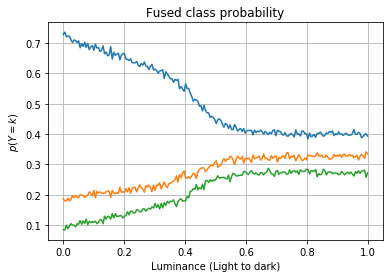

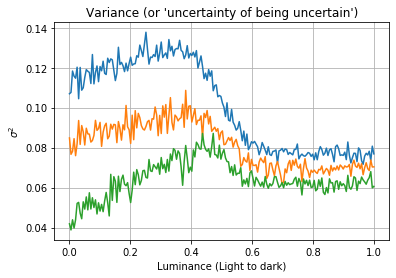

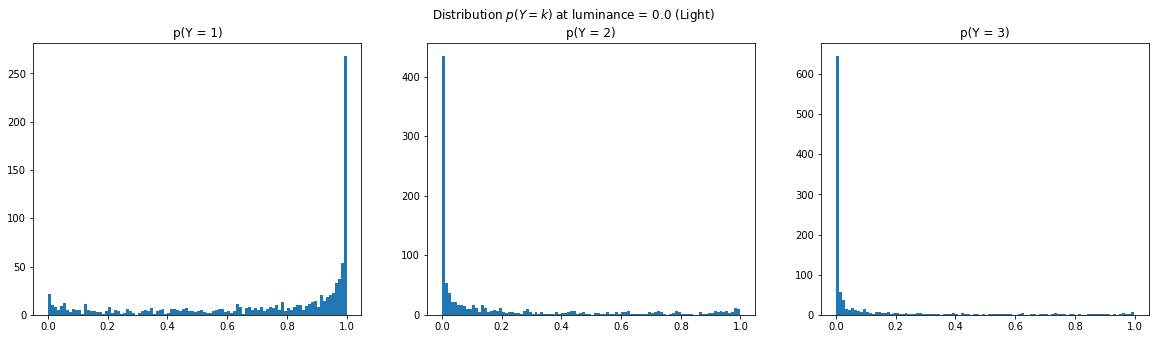

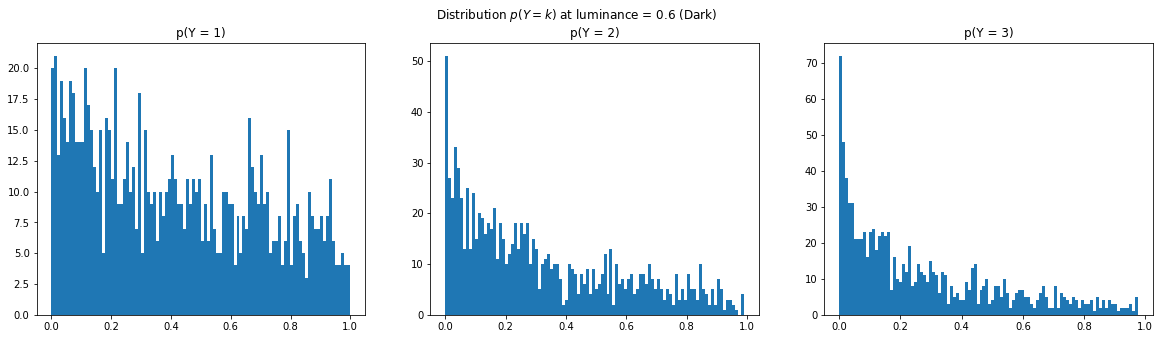

In [13]:
plt.plot(x, fusion_p[0])
plt.plot(x, fusion_p[1])
plt.plot(x, fusion_p[2])
plt.title("Fused class probability")
plt.xlabel("Luminance (Light to dark)")
plt.ylabel("$p(Y = k)$")
plt.grid()
plt.show()

plt.plot(x, fusion_var[0])
plt.plot(x, fusion_var[1])
plt.plot(x, fusion_var[2])
plt.title("Variance (or 'uncertainty of being uncertain')")
plt.xlabel("Luminance (Light to dark)")
plt.ylabel("$\sigma^2$")
plt.grid()
plt.show()

f = plt.figure(figsize=(20,5))
ax = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
ax.hist(probs_y1_distr_0, bins=100)
ax2.hist(probs_y2_distr_0, bins=100)
ax3.hist(probs_y3_distr_0, bins=100)
f.suptitle("Distribution $p(Y=k)$ at luminance = 0.0 (Light)")
ax.set_title("p(Y = 1)")
ax2.set_title("p(Y = 2)")
ax3.set_title("p(Y = 3)")
plt.show()


f = plt.figure(figsize=(20,5))
ax = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
ax.hist(probs_y1_distr_120, bins=100)
ax2.hist(probs_y2_distr_120, bins=100)
ax3.hist(probs_y3_distr_120, bins=100)
f.suptitle("Distribution $p(Y=k)$ at luminance = 0.6 (Dark)")
ax.set_title("p(Y = 1)")
ax2.set_title("p(Y = 2)")
ax3.set_title("p(Y = 3)")
plt.show()

## Case 2: 'Realistic' camera model - output DO NOT reflect true uncertainity

As the environment becomes darker, correctly categorizing objects with a camera becomes more difficult. This behavior is ideally represented by an output which goes towards uniform distribution, that is 'unknown', as luminance goes towards zero. HOWEVER, in real-life, typical DL-based camera models are likely to output erroneous predictions in non-ideal sensing conditions, particularly for input data outside of the training dataset domain. An example of such erroneous prediction is that same object might be classified as different categories at different time with high confidence.

There are no guarantees that the DL training datset will encompass all relevant scenes and environmental variations no matter how many millions of USD one spends on generating labeled datasets (at least if you are not Tesla), and having a prior which hints at when the model is expected to be reliable allows a safer integration of information from different sensors and models. This is demonstrated by the unreliable but high confidence camera model output getting regulated by the more reliable LiDAR model when luminance is low.

### Model observations (evidence)

The observation function represents the classification probability vector as outputted by the corresponding classification model.

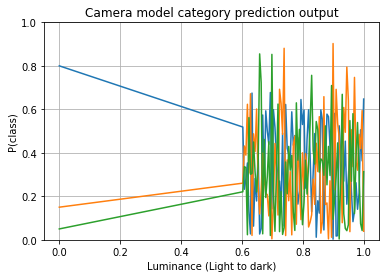

In [14]:
##################
#  Camera model
##################
def p_camera_class_func(x, a_0, b_0, c_0, a, b, c):
    C = np.zeros((3,N))
    
    for i, lum in enumerate(x):
        if i <= 120:
            C[0,i] = a_0 + lum * a
            C[1,i] = b_0 + lum * b
            C[2,i] = c_0 + lum * c
        else:
            
            c0 = np.random.random()*0.7
            c1 = (1 - c0) * np.random.random()
            c2 = 1 - c0 - c1
            
            C[0,i] = c0
            C[1,i] = c1
            C[2,i] = c2
        
    return C

a_0 = 0.8
b_0 = 0.15
c_0 = 0.05

a = -7.0/15.0
b = 11.0/60.0
c = 17.0/60.0

p_camera = p_camera_class_func(x, a_0, b_0, c_0, a, b, c)

plt.plot(x, p_camera[0])
plt.plot(x, p_camera[1])
plt.plot(x, p_camera[2])
plt.title("Camera model category prediction output")
plt.xlabel("Luminance (Light to dark)")
plt.ylabel("P(class)")
plt.grid()
plt.ylim(0,1)
plt.show()

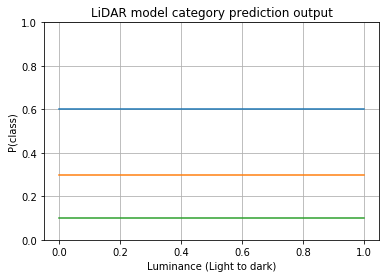

In [15]:
##################
#  LiDAR model
##################
def p_lidar_class_func(x, a, b, c):
    C = np.zeros((3,N))
    
    for i, lum in enumerate(x):
        C[0,i] = a
        C[1,i] = b
        C[2,i] = c
        
    return C

a = 0.6
b = 0.3
c = 0.1

p_lidar = p_lidar_class_func(x, a, b, c)

plt.plot(x, p_lidar[0])
plt.plot(x, p_lidar[1])
plt.plot(x, p_lidar[2])
plt.title("LiDAR model category prediction output")
plt.xlabel("Luminance (Light to dark)")
plt.ylabel("P(class)")
plt.grid()
plt.ylim(0,1)
plt.show()

### Integrate observations and priors

The integration is based on representing the observations and priors in terms of probabilistic distributions. In this problem the domain of the random variable $Y$ consists of $K=3$ states ($Y = 1$ : 'car', $Y = 2$ : 'truck', and $Y = 3$ : 'ambulance'). Each model outputs a classification vector $c = (c_1, \dots, c_k, \dots c_K)$ where each entry $c_k$ corresponds to class probability. 'Unknown' or 'no information' is adequately represented by the uniform categorical distribution $c_k = 1/K \; \forall \; k \in (1, \dots, K)$ which contains no information and therefore can be thought of as complete ignorance regarding the true state (because there must be a single true state!).

The following computations are performed separately for each luminansce value.

### Observations as Categorical (or Multinomial) distributions

Observations, or model output, are modeled as categorical distributions corresponding to the output class probability vector $c$.

$\mathbb{E}[Y=k] = c_k \: \forall \: k \in (1, \dots, K)$

$\sum^K_{k=1} c_k = 1$

In [16]:
K = 3

### Priors as Dirichlet distributions

The prior distribution is designed to "push" the posterior distribution towards $P(Y=1) = 1/K$ ('unknown') in proportion to the specified prior confidence value $C \in (0,1)$. Such a distribution is represented by a Dirichlet distribution centered at $\mu_k = 1/K \: \forall \: k \in (1, \dots, K)$ with variance parametrized by $C$.

$\sigma^2 = C \: \sigma^2_{max}(K)$

where

$\sigma^2_{max} = \frac{K -1}{K^3 + K^2}$

The parameters for the corresponding Dirichlet distribution are then computed as

$a_{prior} = \frac{1}{C \: \sigma^2_{max}(K)} \frac{K - 1}{K^3} - \frac{1}{K}$

This function for $a_{prior}$ has posesses the following necessary properties

$a_{prior} \rightarrow 1$ as $C \rightarrow 1$ (The prior becomes uniform as confidence in the observation increases)

$a_{prior} \rightarrow \infty$ as $C \rightarrow 0$ (The prior becomes stronger as confidence in the observation decreases)

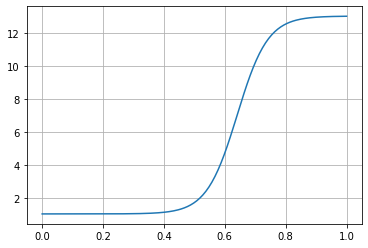

In [17]:
a_prior_camera = np.zeros(N)  # Assumes all classes have the same reliability!

sigma_max = (K - 1.0)/(K**3 + K**2)

for i,conf in enumerate(conf_camera):
    
    a_prior_camera[i] = (1.0 / (conf * sigma_max) ) * ((K - 1.0) / (K**3)) - 1.0 / K
    
plt.plot(x, a_prior_camera)
plt.grid()
plt.show()

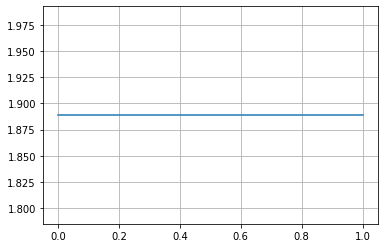

In [18]:
a_prior_lidar = np.zeros(N)  # Assumes all classes have the same reliability!

sigma_max = (K - 1.0)/(K**3 + K**2)

for i,conf in enumerate(conf_lidar):
    
    a_prior_lidar[i] = (1.0 / (conf * sigma_max) ) * ((K - 1.0) / (K**3)) - 1.0 / K

plt.plot(x, a_prior_lidar)
plt.grid()
plt.show()

#### Integration of observations and priors
The Dirichlet distribution is a conjugate prior to the Categorical (or Multinomial) distribution, meaning the posterior distribution becomes another Dirichlet distribution with parameters that can be quickly obtained as an analytical solution.

$a_{post,k} = c_k + a_{prior} - 1$

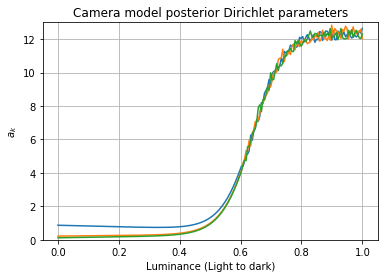

0.340
0.331
0.329
[12.518929655553723, 12.167825744600927, 12.12617881403712]


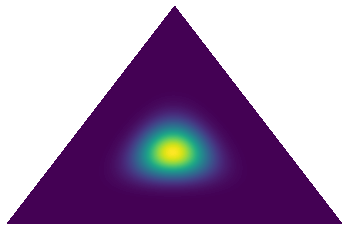

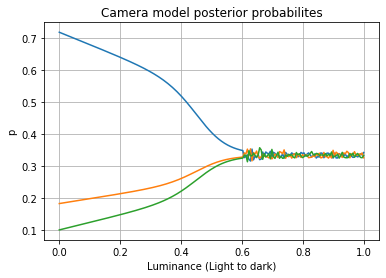

In [19]:
a_post_camera = np.zeros((3,N))  # Class-wise posterior probability distribution parameters

for i in range(N):
    for k in range(K):
        
        a_post_camera[k, i] = p_camera[k, i] + a_prior_camera[i] - 1.0

plt.plot(x, a_post_camera[0])
plt.plot(x, a_post_camera[1])
plt.plot(x, a_post_camera[2])
plt.title("Camera model posterior Dirichlet parameters")
plt.xlabel("Luminance (Light to dark)")
plt.ylabel("$a_k$")
plt.grid()
plt.ylim(0,13)
plt.show()


# Visualize distribution

n = 180
prior_alpha = [a_post_camera[0,n], a_post_camera[1,n], a_post_camera[2,n]]
prior_alpha_0 = sum(prior_alpha)

print(f"{prior_alpha[0]/prior_alpha_0:.3f}")
print(f"{prior_alpha[1]/prior_alpha_0:.3f}")
print(f"{prior_alpha[2]/prior_alpha_0:.3f}")

print(prior_alpha)

f, axes = plt.subplots(figsize=(6,4))
ax = axes#[0, 0]
dist = Dirichlet(prior_alpha)
ax = plot_dirichlet.draw_pdf_contours(ax, dist, prior_alpha)
plt.show()


# Visualize posterior probailities

p_post_camera = np.zeros((3,N))
for i in range(N):
    
    prior_alpha_0 = np.sum(a_post_camera[:,i])
    p_post_camera[0,i] = a_post_camera[0,i] / prior_alpha_0
    p_post_camera[1,i] = a_post_camera[1,i] / prior_alpha_0
    p_post_camera[2,i] = a_post_camera[2,i] / prior_alpha_0

plt.plot(x, p_post_camera[0])
plt.plot(x, p_post_camera[1])
plt.plot(x, p_post_camera[2])
plt.title("Camera model posterior probabilites")
plt.xlabel("Luminance (Light to dark)")
plt.ylabel("p")
plt.grid()
plt.show()

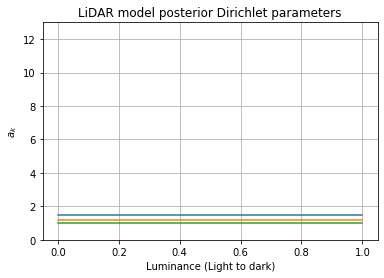

0.406
0.324
0.270
[1.488888888888889, 1.188888888888889, 0.9888888888888892]


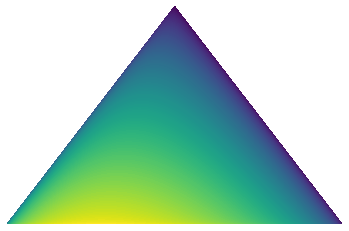

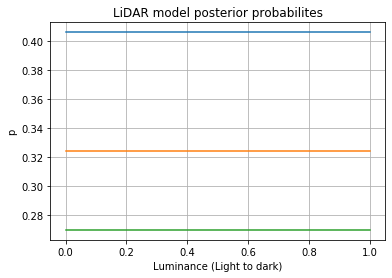

In [20]:
a_post_lidar = np.zeros((3,N))  # Class-wise posterior probability distribution parameters

for i in range(N):
    for k in range(K):
        
        a_post_lidar[k, i] = p_lidar[k, i] + a_prior_lidar[i] - 1.0

plt.plot(x, a_post_lidar[0])
plt.plot(x, a_post_lidar[1])
plt.plot(x, a_post_lidar[2])
plt.title("LiDAR model posterior Dirichlet parameters")
plt.xlabel("Luminance (Light to dark)")
plt.ylabel("$a_k$")
plt.grid()
plt.ylim(0,13)
plt.show()


# Visualize distribution

n = 120
prior_alpha = [a_post_lidar[0,n], a_post_lidar[1,n], a_post_lidar[2,n]]
prior_alpha_0 = sum(prior_alpha)

print(f"{prior_alpha[0]/prior_alpha_0:.3f}")
print(f"{prior_alpha[1]/prior_alpha_0:.3f}")
print(f"{prior_alpha[2]/prior_alpha_0:.3f}")

print(prior_alpha)

f, axes = plt.subplots(figsize=(6,4))
ax = axes#[0, 0]
dist = Dirichlet(prior_alpha)
ax = plot_dirichlet.draw_pdf_contours(ax, dist, prior_alpha)
plt.show()


# Visualize posterior probailities

p_lidar_camera = np.zeros((3,N))
for i in range(N):
    
    prior_alpha_0 = np.sum(a_post_lidar[:,i])
    p_lidar_camera[0,i] = a_post_lidar[0,i] / prior_alpha_0
    p_lidar_camera[1,i] = a_post_lidar[1,i] / prior_alpha_0
    p_lidar_camera[2,i] = a_post_lidar[2,i] / prior_alpha_0

plt.plot(x, p_lidar_camera[0])
plt.plot(x, p_lidar_camera[1])
plt.plot(x, p_lidar_camera[2])
plt.title("LiDAR model posterior probabilites")
plt.xlabel("Luminance (Light to dark)")
plt.ylabel("p")
plt.grid()
plt.show()

### Model fusion using probabilistic inference

The posterior distributions of a variable set of models can be probabilistically fused by modeling the perception system as a Naive-Bayes graphical model using approximate inference to find the probability $P(Y=k|X_1, X_2, \theta)$, according to their relative probability and uncertainty. The fused result can either be represented as a probability distribution, or an expected probability and uncertainty value (expressed as variance).

$P(Y=k | X_1, X_2, \theta) = \frac{P(X_1|Y=k,\theta) \: P(X_2|Y=k,\theta) \: P(Y=k | \theta)}{\sum_{y=(1,2,3)} P(X_1|Y=y) P(Y=y) \: \sum_{y=(1,2,3)} P(X_2|Y=y) P(Y=y)} $

![naive_bayes](https://user-images.githubusercontent.com/34254153/81291173-44b57380-90a4-11ea-8c6b-dcf78845e2a2.png)

In [21]:
def sample_model_y1(a_x1, a_x2):
    '''
    '''
    
    p_y1 = uniform()
    p_y2 = uniform()
    p_y3 = uniform()
    
    p_y_sum = p_y1 + p_y2 + p_y3
    
    p_y1 /= p_y_sum
    p_y2 /= p_y_sum
    p_y3 /= p_y_sum
    
    p_x1 = dirichlet(a_x1)
    
    p_x1_y1 = p_x1[0]
    p_x1_y2 = p_x1[1]
    p_x1_y3 = p_x1[2]
    
    p_x2 = dirichlet(a_x2)
    p_x2_y1 = p_x2[0]
    p_x2_y2 = p_x2[1]
    p_x2_y3 = p_x2[2]
    
    eta = p_x1_y1*p_x2_y1*p_y1 + p_x1_y2*p_x2_y2*p_y2 + p_x1_y3*p_x2_y3*p_y3
    
    prob_y1 = (p_y1 * p_x1_y1 * p_x2_y1) / eta
    
    return prob_y1

def sample_model_y2(a_x1, a_x2):
    '''
    '''
    
    p_y1 = uniform()
    p_y2 = uniform()
    p_y3 = uniform()
    
    p_y_sum = p_y1 + p_y2 + p_y3
    
    p_y1 /= p_y_sum
    p_y2 /= p_y_sum
    p_y3 /= p_y_sum
    
    p_x1 = dirichlet(a_x1)
    
    p_x1_y1 = p_x1[0]
    p_x1_y2 = p_x1[1]
    p_x1_y3 = p_x1[2]
    
    p_x2 = dirichlet(a_x2)
    p_x2_y1 = p_x2[0]
    p_x2_y2 = p_x2[1]
    p_x2_y3 = p_x2[2]
    
    eta = p_x1_y1*p_x2_y1*p_y1 + p_x1_y2*p_x2_y2*p_y2 + p_x1_y3*p_x2_y3*p_y3
    
    prob_y2 = (p_y2 * p_x1_y2 * p_x2_y2) / eta
    
    return prob_y2

def sample_model_y3(a_x1, a_x2):
    '''
    '''
    
    p_y1 = uniform()
    p_y2 = uniform()
    p_y3 = uniform()
    
    p_y_sum = p_y1 + p_y2 + p_y3
    
    p_y1 /= p_y_sum
    p_y2 /= p_y_sum
    p_y3 /= p_y_sum
    
    p_x1 = dirichlet(a_x1)
    
    p_x1_y1 = p_x1[0]
    p_x1_y2 = p_x1[1]
    p_x1_y3 = p_x1[2]
    
    p_x2 = dirichlet(a_x2)
    p_x2_y1 = p_x2[0]
    p_x2_y2 = p_x2[1]
    p_x2_y3 = p_x2[2]
    
    eta = p_x1_y1*p_x2_y1*p_y1 + p_x1_y2*p_x2_y2*p_y2 + p_x1_y3*p_x2_y3*p_y3
    
    prob_y3 = (p_y3 * p_x1_y3 * p_x2_y3) / eta
    
    return prob_y3

In [22]:
fusion_p = np.zeros((3,N))
fusion_var = np.zeros((3,N))

for i in range(N):
    
    probs_y1 = []
    probs_y2 = []
    probs_y3 = []
    
    for j in range(1000):
        
        prob_y1 = sample_model_y1(a_post_camera[:,i], a_post_lidar[:,i])
        prob_y2 = sample_model_y2(a_post_camera[:,i], a_post_lidar[:,i])
        prob_y3 = sample_model_y3(a_post_camera[:,i], a_post_lidar[:,i])
        
        probs_y1.append(prob_y1)
        probs_y2.append(prob_y2)
        probs_y3.append(prob_y3)
        
        
    probs_y1_mean = np.mean(probs_y1)
    probs_y2_mean = np.mean(probs_y2)
    probs_y3_mean = np.mean(probs_y3)
    
    probs_y1_var = np.var(probs_y1)
    probs_y2_var = np.var(probs_y2)
    probs_y3_var = np.var(probs_y3)
    
    norm = probs_y1_mean + probs_y2_mean + probs_y3_mean
    
    probs_y1_mean /= norm
    probs_y2_mean /= norm
    probs_y3_mean /= norm
    
    if i == 0:
        probs_y1_distr_0 = probs_y1
        probs_y2_distr_0 = probs_y2
        probs_y3_distr_0 = probs_y3
    
    if i == 120:
        probs_y1_distr_120 = probs_y1
        probs_y2_distr_120 = probs_y2
        probs_y3_distr_120 = probs_y3
    
    fusion_p[0,i] = probs_y1_mean
    fusion_p[1,i] = probs_y2_mean
    fusion_p[2,i] = probs_y3_mean
    
    fusion_var[0, i] = probs_y1_var
    fusion_var[1, i] = probs_y2_var
    fusion_var[2, i] = probs_y3_var
    

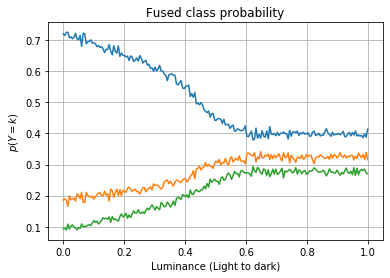

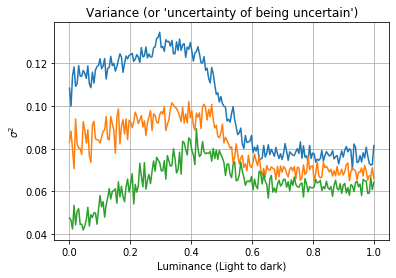

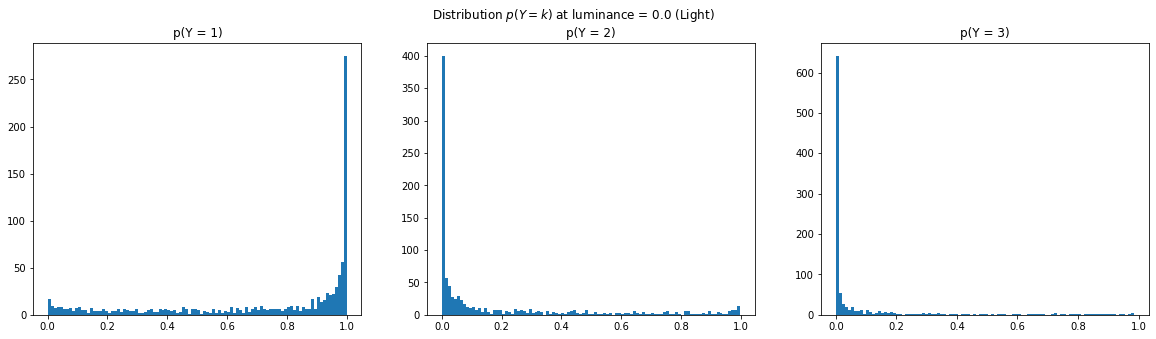

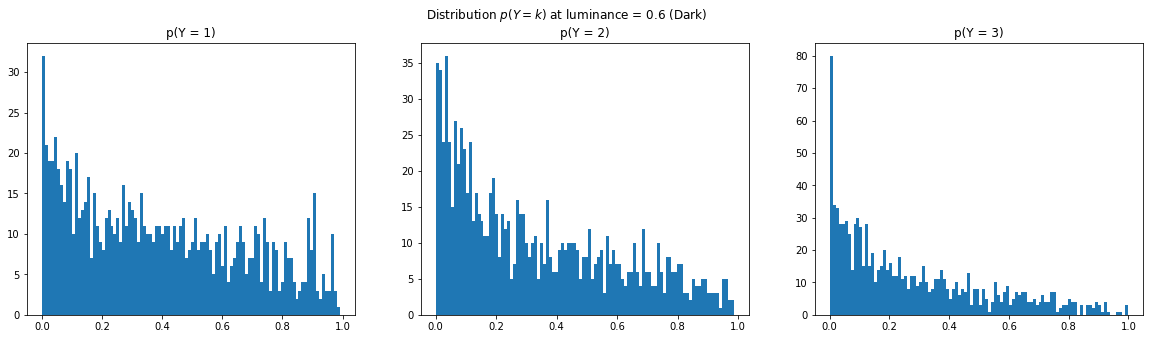

In [23]:
plt.plot(x, fusion_p[0])
plt.plot(x, fusion_p[1])
plt.plot(x, fusion_p[2])
plt.title("Fused class probability")
plt.xlabel("Luminance (Light to dark)")
plt.ylabel("$p(Y = k)$")
plt.grid()
plt.show()

plt.plot(x, fusion_var[0])
plt.plot(x, fusion_var[1])
plt.plot(x, fusion_var[2])
plt.title("Variance (or 'uncertainty of being uncertain')")
plt.xlabel("Luminance (Light to dark)")
plt.ylabel("$\sigma^2$")
plt.grid()
plt.show()


f = plt.figure(figsize=(20,5))
ax = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
ax.hist(probs_y1_distr_0, bins=100)
ax2.hist(probs_y2_distr_0, bins=100)
ax3.hist(probs_y3_distr_0, bins=100)
f.suptitle("Distribution $p(Y=k)$ at luminance = 0.0 (Light)")
ax.set_title("p(Y = 1)")
ax2.set_title("p(Y = 2)")
ax3.set_title("p(Y = 3)")
plt.show()


f = plt.figure(figsize=(20,5))
ax = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
ax.hist(probs_y1_distr_120, bins=100)
ax2.hist(probs_y2_distr_120, bins=100)
ax3.hist(probs_y3_distr_120, bins=100)
f.suptitle("Distribution $p(Y=k)$ at luminance = 0.6 (Dark)")
ax.set_title("p(Y = 1)")
ax2.set_title("p(Y = 2)")
ax3.set_title("p(Y = 3)")
plt.show()